In [2]:
#Import necessary modules

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek


In [3]:
#Load cleaned dataset
ppi_clean=pd.read_csv("/kaggle/input/dataset/data_clean.csv")
ppi_clean

,domain,aa_ProtPosition,uniprot_id,hydrophobicity_scores,Rlength,normalized_length,normalized_abs_surf_acc,normalized_hydropathy_index,rel_surf_acc,prob_sheet,...,9_wm_pssm_M,9_wm_pssm_F,9_wm_pssm_P,9_wm_pssm_S,9_wm_pssm_T,9_wm_pssm_W,9_wm_pssm_Y,9_wm_pssm_V,p_interface,hydrophobicity_scores.1
0,0,1,A0A024RAV5,0.64,188,0.238095,0.784319,0.711111,0.803,0.003,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0,0.64
1,0,2,A0A024RAV5,-0.05,188,0.238095,0.359207,0.422222,0.530,0.047,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0,-0.05
2,0,3,A0A024RAV5,-0.74,188,0.238095,0.395387,0.111111,0.464,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0,-0.74
3,0,4,A0A024RAV5,0.26,188,0.238095,0.401655,0.355556,0.385,0.084,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0,0.26
4,1,5,A0A024RAV5,-1.50,188,0.238095,0.288103,0.066667,0.287,0.084,...,0.436017,0.238759,0.103980,0.105653,0.161544,0.060391,0.140326,0.481904,0,-1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65145,1,34,P0A427,1.38,38,0.014881,0.210794,1.000000,0.233,0.086,...,0.374128,0.415754,0.109332,0.351726,0.330383,0.241807,0.334863,0.381730,1,1.38
65146,0,35,P0A427,-0.74,38,0.014881,0.292872,0.111111,0.343,0.086,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1,-0.74
65147,0,36,P0A427,0.48,38,0.014881,0.141193,0.455556,0.367,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1,0.48
65148,0,37,P0A427,-0.74,38,0.014881,0.406473,0.111111,0.477,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1,-0.74


Text(0.5, 1.0, 'Class Distribution of the ppi dataset')

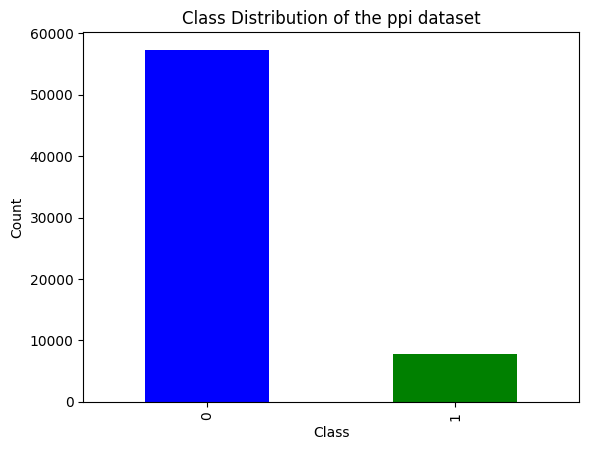

In [4]:
#Check for class distribution

class_counts=ppi_clean["p_interface"].value_counts()
class_counts.plot(kind="bar",color=["blue","green"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution of the ppi dataset")


In [5]:
#Load train data
train_data = pd.read_csv("/kaggle/input/dataset/ppi_clean_train.csv")
train_data

,domain,aa_ProtPosition,uniprot_id,hydrophobicity_scores,Rlength,normalized_length,normalized_abs_surf_acc,normalized_hydropathy_index,rel_surf_acc,prob_sheet,...,9_wm_pssm_K,9_wm_pssm_M,9_wm_pssm_F,9_wm_pssm_P,9_wm_pssm_S,9_wm_pssm_T,9_wm_pssm_W,9_wm_pssm_Y,9_wm_pssm_V,p_interface
0,0,1,Q503K9,0.64,99,0.105655,0.762537,0.711111,0.781,0.003,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
1,0,2,Q503K9,0.12,99,0.105655,0.228813,0.322222,0.330,0.017,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
2,0,3,Q503K9,-0.18,99,0.105655,0.291686,0.411111,0.510,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
3,0,4,Q503K9,-1.50,99,0.105655,0.374165,0.066667,0.373,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
4,1,5,Q503K9,1.06,99,0.105655,0.254662,0.922222,0.285,0.043,...,0.236424,0.385451,0.040772,0.237208,0.386928,0.315001,0.060391,0.039517,0.197994,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52022,1,34,P0A427,1.38,38,0.014881,0.210794,1.000000,0.233,0.086,...,0.286923,0.374128,0.415754,0.109332,0.351726,0.330383,0.241807,0.334863,0.381730,1
52023,0,35,P0A427,-0.74,38,0.014881,0.292872,0.111111,0.343,0.086,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
52024,0,36,P0A427,0.48,38,0.014881,0.141193,0.455556,0.367,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1
52025,0,37,P0A427,-0.74,38,0.014881,0.406473,0.111111,0.477,0.043,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1


In [6]:
#Remove unnecessary features
def remove_non_features(df: pd.DataFrame, non_feature_cols: list[str]) -> pd.DataFrame:
    return df.drop(non_feature_cols, axis=1)

In [7]:
#Split train/validation and test sets based on UNIPROT IDS
from sklearn.model_selection import GroupShuffleSplit

def split_data_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, **kwargs) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    gss = GroupShuffleSplit(**kwargs)

    for train_idx, test_idx in gss.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

    assert set(X_train.uniprot_id).intersection(set(X_test.uniprot_id)) == set(), 'The same uniprot ID appears in both the train and test set!'
    return X_train, X_test, y_train, y_test

X_tv = train_data.drop('p_interface', axis=1)
y_tv = train_data.p_interface
groups = train_data.uniprot_id

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier

def kfold_cv_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, **kwargs) -> pd.DataFrame:
    group_kfold = GroupKFold(**kwargs)

    resampling_methods = {
        "Original": None,
        "SMOTE": SMOTE(sampling_strategy='auto', random_state=42),
        "Random Under": RandomUnderSampler(random_state=42),
        "ADASYN": ADASYN(sampling_strategy='auto', random_state=42),
        "SMOTE-Tomek": SMOTETomek(random_state=42)
    }

    param_grid = {
        'max_depth': [5, 10, 20, 25],
        'min_samples_leaf': [4, 8, 16, 32, 64, 128]
    }

    result_data = {
        'resampling_method': [],
        'best_max_depth': [],
        'best_min_samples_leaf': [],
        'best_avg_auc': [],
    }

    # Loop through different resampling methods
    for method_name, resampler in resampling_methods.items():
        print(f"\nApplying {method_name} resampling...")

        best_avg_auc = -1
        best_params = None

        # Loop through hyperparameter combinations
        for min_samples_leaf in param_grid['min_samples_leaf']:
            for max_depth in param_grid['max_depth']:
                fold_aucs = []  # Store AUC scores for each fold

                # Perform cross-validation
                for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups)):
                    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                    # Perform resampling if needed
                    if resampler is not None:
                        X_train, y_train = resampler.fit_resample(X_train, y_train)

                    # Train model with current hyperparameters
                    model = RandomForestClassifier(
                        class_weight='balanced', 
                        criterion='gini', 
                        n_estimators=200, 
                        max_features='log2',
                        max_depth=max_depth,
                        min_samples_leaf=min_samples_leaf,
                        random_state=42
                    )
                    model.fit(X_train, y_train)

                    # Evaluate on validation set
                    y_pred_proba = model.predict_proba(X_val)[:, 1]
                    auc_score = roc_auc_score(y_val, y_pred_proba)
                    class_report = classification_report(y_val, y_pred_labels, output_dict=True,zero_division=0)

                    fold_aucs.append(auc_score)

                #average AUC across folds
                avg_auc = np.mean(fold_aucs)

                #best parameter combination
                if avg_auc > best_avg_auc:
                    best_avg_auc = avg_auc
                    best_params = (max_depth, min_samples_leaf)

      
        result_data['resampling_method'].append(method_name)
        result_data['best_max_depth'].append(best_params[0])
        result_data['best_min_samples_leaf'].append(best_params[1])
        result_data['best_avg_auc'].append(best_avg_auc)

        print(f"Best params for {method_name}: max_depth={best_params[0]}, min_samples_leaf={best_params[1]}, avg AUC={best_avg_auc:.4f}")

    # Convert to DataFrame and return
    result_df = pd.DataFrame(result_data)
    return result_df

# Define data
non_feature_cols = ['domain', 'aa_ProtPosition', 'uniprot_id']
X = remove_non_features(X_tv, non_feature_cols)
y = y_tv
groups = X_tv.uniprot_id

# Run the function
model_results = kfold_cv_by_group(X, y, groups, n_splits=5)
print(model_results)  



Applying Original resampling...
Best params for Original: max_depth=20, min_samples_leaf=64, avg AUC=0.6944

Applying SMOTE resampling...
Best params for SMOTE: max_depth=25, min_samples_leaf=32, avg AUC=0.6917

Applying Random Under resampling...
Best params for Random Under: max_depth=20, min_samples_leaf=8, avg AUC=0.6924

Applying ADASYN resampling...
Best params for ADASYN: max_depth=25, min_samples_leaf=16, avg AUC=0.6873

Applying SMOTE-Tomek resampling...
Best params for SMOTE-Tomek: max_depth=25, min_samples_leaf=32, avg AUC=0.6914
  resampling_method  best_max_depth  best_min_samples_leaf  best_avg_auc
0          Original              20                     64      0.694354
1             SMOTE              25                     32      0.691668
2      Random Under              20                      8      0.692363
3            ADASYN              25                     16      0.687332
4       SMOTE-Tomek              25                     32      0.691442


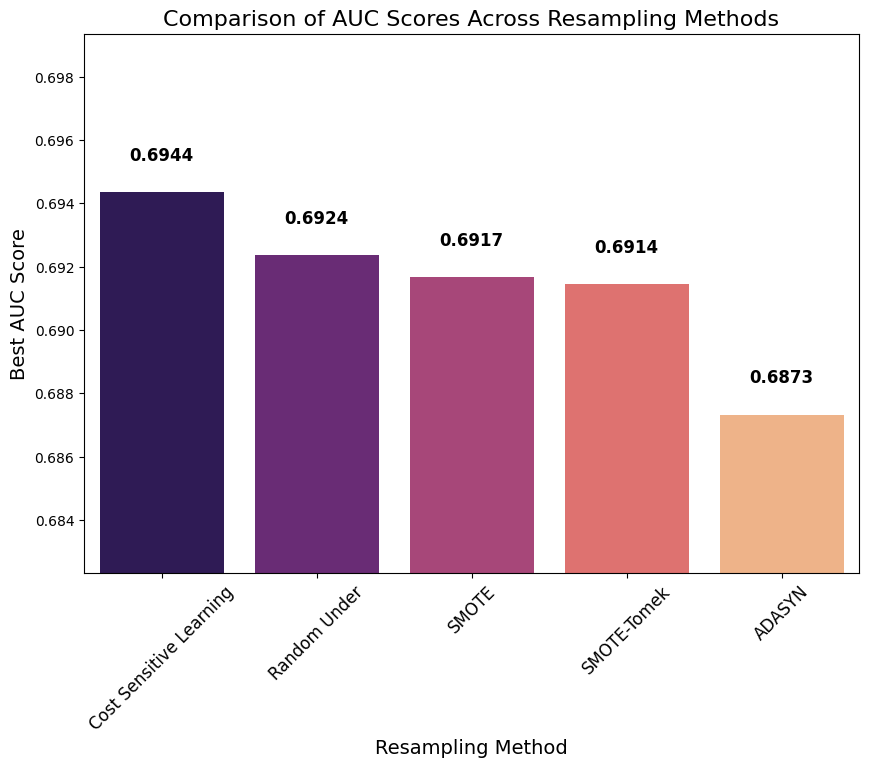

In [14]:
plt.figure(figsize=(10, 7))

# Rename to "Cost Sensitive Learning"
model_results = model_results.copy()  # Avoid modifying the original DataFrame
model_results.loc[0, "resampling_method"] = "Cost Sensitive Learning"

# Sort for better visualization
model_results = model_results.sort_values(by="best_avg_auc", ascending=False)

# Plot
sns.barplot(data=model_results, x="resampling_method", y="best_avg_auc", palette="magma")

# Add data labels
for index, row in enumerate(model_results.itertuples()):
    plt.text(index, row.best_avg_auc + 0.001, f"{row.best_avg_auc:.4f}", ha='center', fontsize=12, fontweight='bold')

# Labels and title
plt.xlabel("Resampling Method", fontsize=14)
plt.ylabel("Best AUC Score", fontsize=14)
plt.title("Comparison of AUC Scores Across Resampling Methods", fontsize=16)
plt.xticks(rotation=45, fontsize=12)

# Dynamically adjust the y-axis scale based on min and max AUC values
min_auc, max_auc = model_results["best_avg_auc"].min(), model_results["best_avg_auc"].max()
plt.ylim(min_auc - 0.005, max_auc + 0.005)  # Small buffer around min/max for better visualization

plt.show()

NameError: name 'scores_df' is not defined

<Figure size 800x500 with 0 Axes>